In [1]:
import os

import numpy as np

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split, Subset
from torchvision.datasets import ImageFolder

from sklearn.model_selection import StratifiedShuffleSplit

import matplotlib.pyplot as plt
import random

import PIL

import shutil
from pathlib import Path

# set the device to GPU if available:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
    
torch.cuda.empty_cache()

Cuda installed! Running on GPU!


In [2]:
os.listdir('../input/acse-miniproject/')

['train', 'mapping.py', 'mapping.json', 'test']

In [3]:
out_path = '../working/out'
in_path = '../input/acse-miniproject/'

# check if we have the output working directory, if not then create it
if not os.path.isdir(out_path):
    os.mkdir(out_path)
    
print(os.listdir(out_path))

[]


## Introduction

- This notebook will do some exploratory data analysis to try and gain some more information about the datasets, and how they may end up driving the analysis

## Loading the Data

- This section will load the data from the folders so they can be used for the analysis


- The ***CustomImageTensorDataset*** function, which was used through the project, is used here to apply the normalization transformation to the samples in the test data


- The ***ImageFolderWithPaths*** function is used to get the images including their corresponding filenames. This allows the construction of the csv meeting the required submission format

In [4]:
# define a custom image dataset class - this will be reused whenever we wish to load data into a dataloader
class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]        
        sample = torch.from_numpy(sample).permute(2, 0, 1)/255. #torch.from_numpy(sample).permute(2, 0, 1)/255.
        if self.transform:
            sample = self.transform(sample) #self.transform(image=sample)['image'] 
        return sample, label

train_path = in_path+'/train/'
test_path = in_path+'/test/'

# grab the dataset structure (this does not read files in, rather it creates a map of files and labels)
train_data_raw = ImageFolder(train_path, transform=None)
test_data = ImageFolder(test_path, transform=None)

# check that we have the files in the right place
print('number of training samples (expect 100000):', len(train_data_raw))
print('number of training set classes (expect 200):', len(os.listdir(train_path)))
print('number of test classes (expect 1):', len(os.listdir(test_path)))

number of training samples (expect 100000): 100000
number of training set classes (expect 200): 200
number of test classes (expect 1): 1


## Check the Number of Grayscale Images

-  The project brief mentioned some of the images are grayscale. In order to assess how to move forward, we plotted analyzed the number of black and white images. If the proportion of grayscale images was high, it would make sense to try converting **ALL** our images to either grayscale versions and see if that would make any difference

- We found the number of grayscale images to be small such that we did not convert all our images. In addition, the color channels are likely to be an important source of information for the neural net

In [5]:
# first we will get the filepaths and their labels (do not fetch the images as that is slow)
X_paths = np.empty(len(train_data_raw), dtype=object)
y_labels = np.empty(len(train_data_raw), dtype=int)

# grab the paths and the filenames
for i, (path, class_idx) in enumerate(train_data_raw.samples):
    X_paths[i] = path
    y_labels[i] = class_idx

In [6]:
def count_bw(X_set_paths, y_labels):
    """
    A function to count the number of grayscale images, based on the third channel dimension
    Args:
        X_set_paths (np.array): An array containing filepaths to images in the data set
        y_labels (Tensor): classification labels corresponding to the images in the dataset
    """
    
    
    # create a dictionary to hold the black and white image counts
    counts = dict.fromkeys(list(train_data_raw.class_to_idx.values()), 0)
    
    for i, (filename, label) in enumerate(zip(X_set_paths, y_labels)):
        X = np.array(PIL.Image.open(filename))
        if X.shape == (64, 64):
            counts[label] += 1 
    return counts
            
counts = count_bw(X_paths, y_labels)

In [7]:
bw_count = sum(list(counts.values()))
print('total number of grayscale images:', bw_count, '\tas a percentage of total dataset:', bw_count/100000.)

total number of grayscale images: 1821 	as a percentage of total dataset: 0.01821


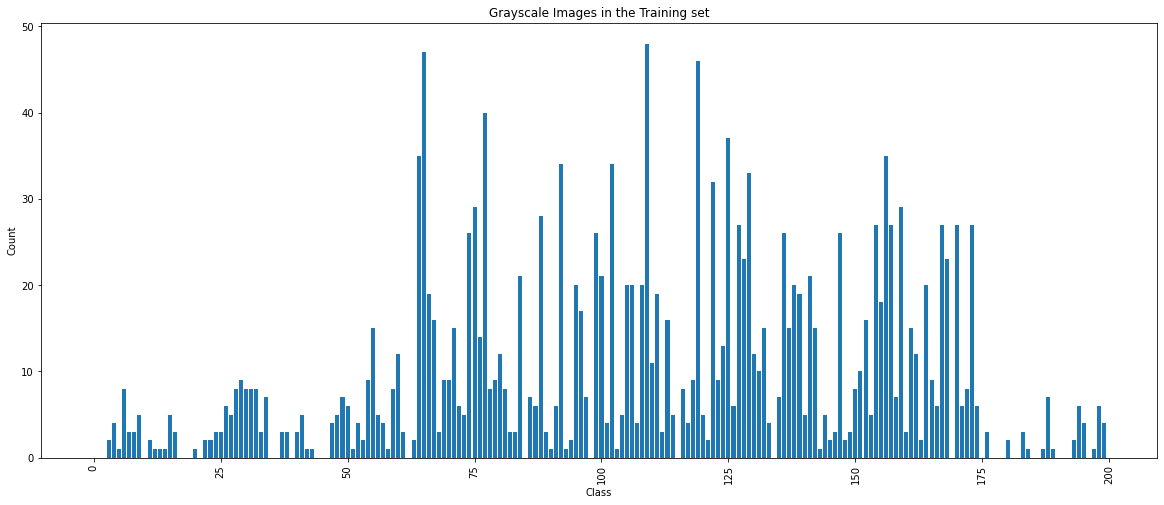

In [8]:
# the below plots a histogram based on the counts above
fig, axs = plt.subplots(1, 1, figsize=(20, 8))
axs.bar(counts.keys(), counts.values())
axs.set_title('Grayscale Images in the Training set')
axs.set_ylabel('Count')
axs.set_xlabel('Class')
plt.xticks(rotation=90)
plt.show()

#### Comments
As can be seen from the chart above, the number of grayscale images is relatively small, so we can simply convert them to 3 channel images safely without worrying too much about how it will impact out normalization and neural network training.

## Comparison of Stratified Shuffle Split and Random Split

- In order to get the data ready for the training and validation, we compared two approaches

-  We found that in practice, for a large enough dataset the performance of the two methods is roughly the same

In [9]:
# grab the labels in the raw training data
y_labels = np.array([e[1] for e in train_data_raw])

#### Stratified Shuffle Split

- First the Stratified Shuffle Split will be used to split the data into training and validation sets. This will give a good base for comparison when we run Stratified Shuffle Split

In [10]:
# split the 100k points into a training and validation data; 90-10% split
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(train_data_raw, y_labels)

# pull out the indices of the data we will keep
train_idx, valid_idx = next(shuffler)

# print and check the shapes of both indices arrays. These are as expected
print('train indices shape: ', train_idx.shape, 'validation indices shape: ', valid_idx.shape)

train indices shape:  (90000,) validation indices shape:  (10000,)


In [11]:
train_data = Subset(train_data_raw, train_idx)
validation_data = Subset(train_data_raw, valid_idx)

print('length of training set:', len(train_data), 'length of validation set:', len(validation_data))

length of training set: 90000 length of validation set: 10000


#### Plotting the Training and Validation Splits by Label - Stratified Shuffle Split

- We can see below that the stratified shuffle split works pretty well in splitting the data as required

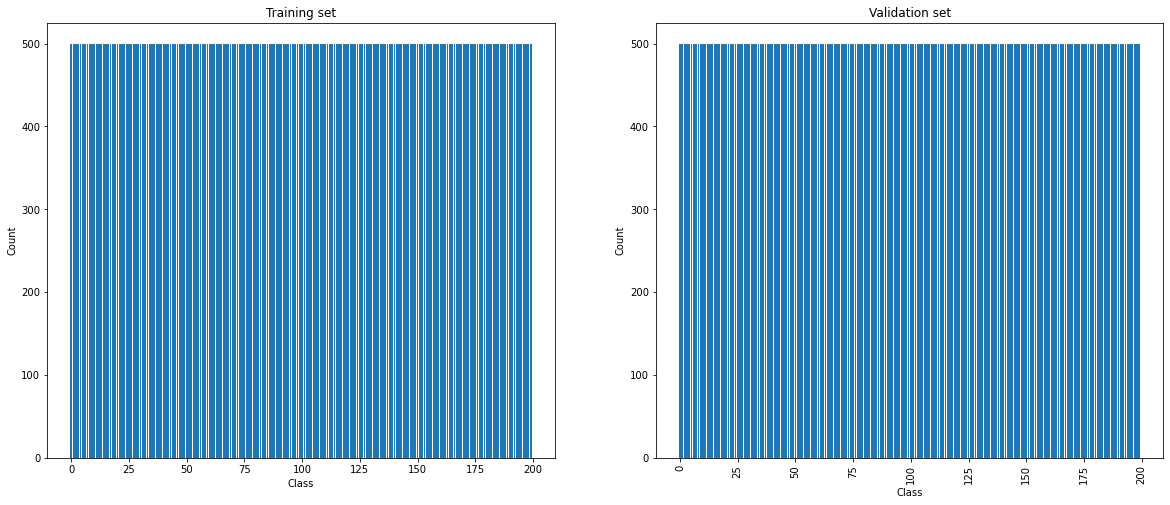

In [12]:
from collections import Counter

count_train = Counter(elem[1] for elem in train_data.dataset)
count_valid = Counter(elem[1] for elem in validation_data.dataset)

# the below plots a histogram
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].bar(count_train.keys(), count_train.values())
axs[0].set_title('Training set')
axs[0].set_ylabel('Count')
axs[0].set_xlabel('Class')
axs[1].bar(count_valid.keys(), count_valid.values())
axs[1].set_title('Validation set')
axs[1].set_ylabel('Count')
axs[1].set_xlabel('Class')
plt.xticks(rotation=90)
plt.show()

#### Plotting the Training and Validation Splits by Label - Random Split

- Not surprisingly, if we use a big enough chunk of the dataset, Pytorch's Random Split also gives an even distribution across the classes

- Given the ease of use, we use Pytorch's ***random_split*** function in our analysis

In [13]:
# now create the split using random split function
train_size = int(0.9 * len(train_data_raw))
validation_size = len(train_data_raw) - train_size
train_dataset, validation_dataset = random_split(train_data_raw, [train_size, validation_size])

print('length of training set:', len(train_dataset), 'length of validation set:', len(validation_dataset))

length of training set: 90000 length of validation set: 10000


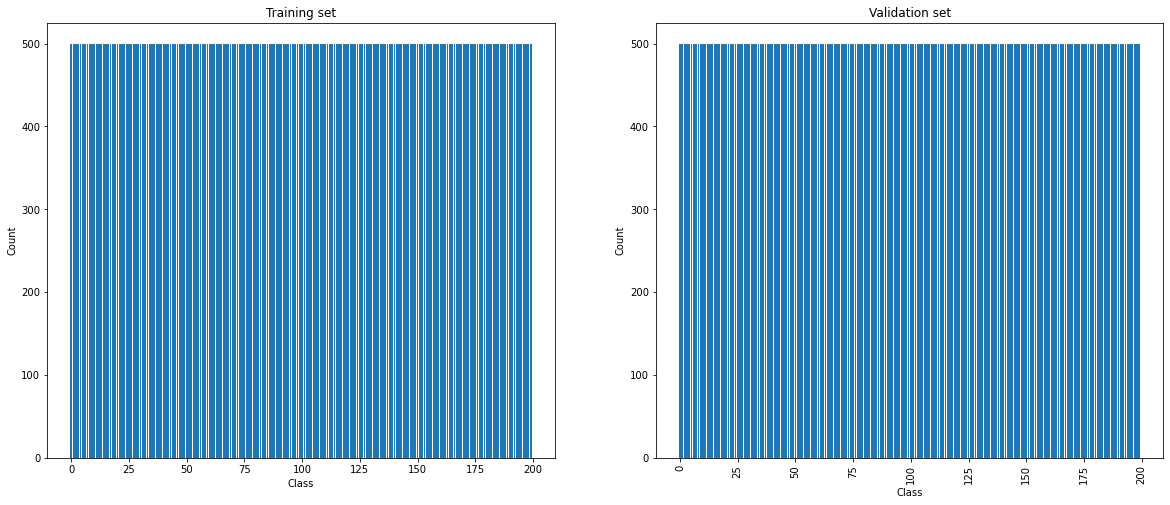

In [14]:
count_train = Counter(elem[1] for elem in train_dataset.dataset)
count_valid = Counter(elem[1] for elem in validation_dataset.dataset)

# the below plots a histogram
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
axs[0].bar(count_train.keys(), count_train.values())
axs[0].set_title('Training set')
axs[0].set_ylabel('Count')
axs[0].set_xlabel('Class')
axs[1].bar(count_valid.keys(), count_valid.values())
axs[1].set_title('Validation set')
axs[1].set_ylabel('Count')
axs[1].set_xlabel('Class')
plt.xticks(rotation=90)
plt.show()

## Plotting Some Examples from our Dataset

- Here we plot some images from the dataset. I use the validation set as it is smaller and so a bit quicker to loop over and find the images we are looking for demonstration purposes.

How many goldfish do we have: 9
9


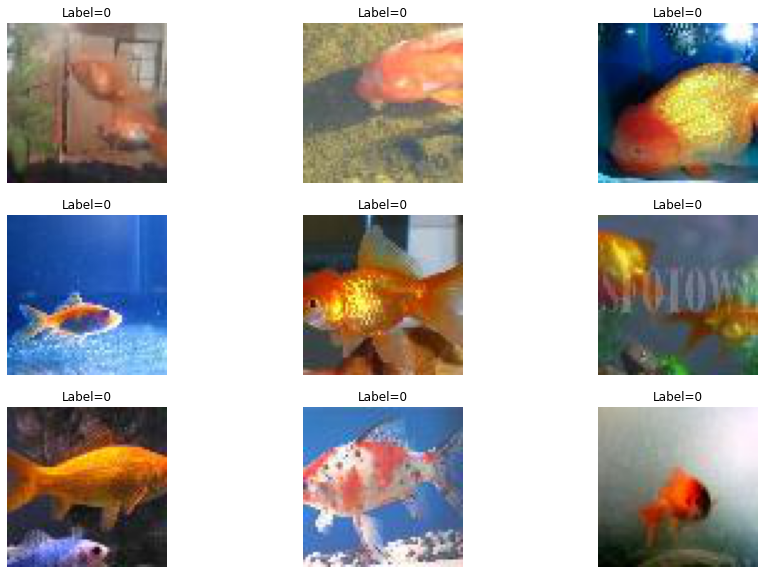

In [15]:
def grab_image(label, number, data_set):
    """
    A function that grabs a number of images for a specified label
    Args:
        label (int): The label class that the user wants to plot
        number (int): the number of images to grab
    """
    count = 0
    images, labels = [], []
    
    # loop through the validation data and grab some data points
    for img, label in data_set:
        if label == 0:
            images.append(img)
            labels.append(label)
            count += 1
        if count == number:
            break
    return images, labels

# grab the fishes
fishes, labels = grab_image(0, 9, validation_data)

print('How many goldfish do we have:', len(fishes))

print(len(fishes))

# index to iterate through the sample images
fig, axs = plt.subplots(3, 3, figsize=(15,10))

idx = 0

# simply loop and plot 0 images and their corresponding label from the training set. This is done before the training/validation split
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(fishes[idx])
        axs[i, j].set_title('Label={}'.format(labels[idx]))
        axs[i, j].axis('off')
        idx += 1
plt.show()

## Preprocess the Data

- Find the normalization statistics from the training data. This can give us insight into whether the dataset is skewed toward any particular channel. As can be seen from below, it appears that the 3 channels are relatively well balanced throughout the dataset

In [16]:
def get_stats(data_set):
    n = len(data_set)
    X_set, y_set = [], []    
    meanRGB = np.array([0., 0., 0.])
    stdRGB = np.array([0., 0., 0.])

    for i, (img, label) in enumerate(data_set):
        X = np.array(img)
        X_set.append(X)
        y_set.append(label)
        meanRGB += [(X[:, :, i]/255.).mean() for i in range(3)]
        stdRGB += [(X[:, :, i]/255.).std() for i in range(3)]

    return np.array(X_set), np.array(y_set), meanRGB/n, stdRGB/n
    
X_train, y_train, means, stdevs = get_stats(train_data)
X_valid, y_valid, _, _ = get_stats(validation_data)
print('means:', means, 'stdevs: ', stdevs)
print('Training and validation set shape:', X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

means: [0.48038021 0.44819179 0.39750655] stdevs:  [0.23016943 0.22646676 0.22610976]
Training and validation set shape: (90000, 64, 64, 3) (90000,) (10000, 64, 64, 3) (10000,)


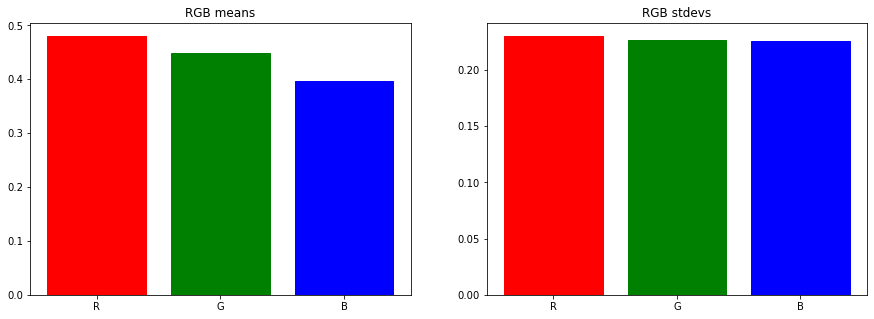

In [17]:
channels = ['R', 'G', 'B']

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

bar_0 = axs[0].bar(channels, means)
axs[0].set_title('RGB means')
bar_0[0].set_color('r')
bar_0[1].set_color('g')
bar_0[2].set_color('b')

bar_1 = axs[1].bar(channels, stdevs)
axs[1].set_title('RGB stdevs')
bar_1[0].set_color('r')
bar_1[1].set_color('g')
bar_1[2].set_color('b')
plt.show()